# **Import:**

Usual import packages for machine learning are required:

In [36]:
from __future__ import print_function

import torch
import torch.nn as nn

import torch.nn.functional as F
import torch.backends.cudnn as cudnn

import torchvision
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torch.utils.data import DataLoader
import torch.nn.init as init

from torch.autograd import Variable
from torchvision import  models

import math

from datetime import datetime
import numpy as np

import os
import sys
import time
import argparse


from torch.autograd import Variable

from tqdm.autonotebook import tqdm
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import inspect
import time
from torch import nn, optim

from torchvision.transforms import Compose, ToTensor, Normalize, Resize, RandomErasing , RandomHorizontalFlip, RandomVerticalFlip, RandomRotation,ColorJitter

import torchvision.datasets
import matplotlib.pyplot as plt


# **GPU Check:**

This code runs only with high GPU memory cards .Please make sure you have enough(16 Gigabytes)! The code was peformed on Tesla P-100.

In [37]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Sat Dec  5 18:56:13 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.45.01    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   65C    P0    39W / 250W |   6061MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# **Load data:**

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [35]:

train_transform=transforms.Compose([
                              transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),])

test_transform=transforms.Compose([
                                transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),]
                              )
       




mnist_train_set = torchvision.datasets.ImageFolder(
root = "drive/MyDrive/food11_biggest/training",
transform = train_transform)


mnist_test_set = torchvision.datasets.ImageFolder(
    root = "drive/MyDrive/food11_biggest/evaluation",
    transform = test_transform)
    
    

train_loader = DataLoader(mnist_train_set, batch_size=32, shuffle=True)
val_loader = DataLoader(mnist_test_set,batch_size=32)


In [20]:
print(len(train_loader))

108


# **Model:**

In [38]:
vgg16 = models.wide_resnet50_2(pretrained=True)

Let's have a look at our model for a second.....

In [39]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = vgg16.to(device)
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), strid

In [40]:
model=vgg16
model.cuda()
model = torch.nn.DataParallel(model, device_ids=range(torch.cuda.device_count()))
cudnn.benchmark = True

# **Metrics Functions:**

Metrics to calculate and identificate the quality of the model perfomance

In [41]:
def calculate_metric(metric_fn, true_y, pred_y):
    if "average" in inspect.getfullargspec(metric_fn).args:
        return metric_fn(true_y, pred_y, average="macro")
    else:
        return metric_fn(true_y, pred_y)
    
def print_scores(p, r, f1, a, batch_size):
    for name, scores in zip(("precision", "recall", "F1", "accuracy"), (p, r, f1, a)):
        print(f"\t{name.rjust(14, ' ')}: {sum(scores)/batch_size:.4f}")
      

# **Best Checkpoint:**

The best checkpoint saving function

In [42]:
# Keep only a single checkpoint, the best over test accuracy.
def save_checkpoint(state, is_best, filename='drive/MyDrive/Colab Notebooks/DSCS/best_mnist_checkpoint.pt'):
    """Save checkpoint if a new best is achieved"""
    if is_best:
        print ("=> Saving a new best")
        torch.save(state, filename)  # save checkpoint
    else:
        print ("=> Validation Accuracy did not improve")


# **Training:**

Training code and evaluating code for the model chosen .
Returns validation loss,and  loss, accuracy, recall , precision and f1 measure on the validation set

In [47]:
start_ts = time.time()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
epochs = 200
best_accuracy = torch.FloatTensor([0])
batch_size=32
model=vgg16
model.to(device)
checkpoint = torch.load('drive/MyDrive/Colab Notebooks/DSCS/best_mnist_checkpoint.pt')
model.load_state_dict(checkpoint['state_dict'])
test_accuracy=[]
losses = []
loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(),
                      lr=0.0001,
                      momentum=0.9,
                      nesterov=True,
                      weight_decay=5e-4)


  

batches = len(train_loader)
val_batches = len(val_loader)

# training loop + eval loop
for epoch in range(epochs):
    total_loss = 0
    progress = tqdm(enumerate(train_loader), desc="Loss: ", total=batches)
    model.train()
    
    for i, data in progress:
        X, y = data[0].to(device), data[1].to(device)
        
        model.zero_grad()
        outputs = model(X)
        loss = loss_function(outputs, y)

        loss.backward()
        optimizer.step()
        current_loss = loss.item()
        total_loss += current_loss
        progress.set_description("Loss: {:.4f}".format(total_loss/(i+1)))
        
    torch.cuda.empty_cache()
    
    val_losses = 0
    precision, recall, f1, accuracy = [], [], [], []
    
    model.eval()
    with torch.no_grad():
        for i, data in enumerate(val_loader):
            X, y = data[0].to(device), data[1].to(device)
            outputs = model(X)
            val_losses += loss_function(outputs, y)

            predicted_classes = torch.max(outputs, 1)[1]
            
            for acc, metric in zip((precision, recall, f1, accuracy), 
                                   (precision_score, recall_score, f1_score, accuracy_score)):
                acc.append(
                    calculate_metric(metric, y.cpu(), predicted_classes.cpu())
                )
        
        
      
    print(f"Epoch {epoch+1}/{epochs}, training loss: {total_loss/batches}, validation loss: {val_losses/val_batches}")
    print_scores(precision, recall, f1, accuracy, val_batches)
    losses.append(total_loss/batches)
    accuracy= sum(accuracy)/val_batches
    test_accuracy.append(accuracy)
    
    accuracy = torch.FloatTensor([accuracy])
    # Get bool not ByteTensor
    is_best = bool(accuracy.numpy() > best_accuracy.numpy())
    # Get greater Tensor to keep track best acc
    best_accuracy = torch.FloatTensor(max(accuracy.numpy(), best_accuracy.numpy()))
    # Save checkpoint if is a new best
    save_checkpoint({
        'epoch': epoch + 1,
        'state_dict': model.state_dict(),
        'best_accuracy': best_accuracy
    }, is_best)  
    torch.save(model.state_dict(), "final_mnist_checkpoint.pt")
print(losses)
print(f"Training time: {time.time()-start_ts}s")


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/200, training loss: 1.2670563469041127, validation loss: 1.0481826066970825
	     precision: 0.1907
	        recall: 0.1348
	            F1: 0.1552
	      accuracy: 0.6521
=> Saving a new best



Epoch 2/200, training loss: 1.27501867774235, validation loss: 1.0418319702148438
	     precision: 0.1947
	        recall: 0.1394
	            F1: 0.1595
	      accuracy: 0.6545
=> Saving a new best



Epoch 3/200, training loss: 1.2652399993251442, validation loss: 1.045485258102417
	     precision: 0.1914
	        recall: 0.1352
	            F1: 0.1557
	      accuracy: 0.6515
=> Validation Accuracy did not improve


KeyboardInterrupt: ignored

# **Plot graph:**

Graph plotting function to see how the loss on the train set conveges and to note how accuracy on the test set varies with the increasing number of epochs

In [48]:
import matplotlib.pyplot as plt
def plot_performance(perf_list, name):

    """
    This function plots the losses and accuarcies we've recorded during the training.
    
    :param perf_list: list with performance values for each epoch.
    :param name: output image name.
    
    Plot the losses and accuracies over epochs in one plot. 
    """

    
    
    if name=='loss':
      
      plt.plot(perf_list)
      ax = plt.axes()
      ticks = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/1000))
      ax.xaxis.set_major_formatter(ticks)
    else:
      plt.plot(range(1,(len(perf_list))+1),perf_list)
    plt.title(name)
    
    
    
    
    #Show figure and save it
    
    plt.savefig(f"./{name}.png")    
    plt.show();

Let's see....

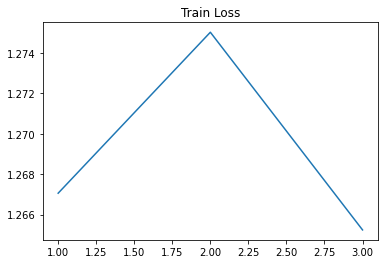

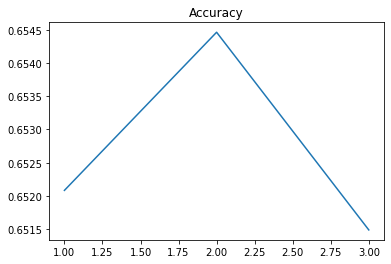

In [49]:

plot_performance(losses, "Train Loss")
plot_performance(test_accuracy, "Accuracy")